# Central model training 

In [ ]:
!pip install --quiet carbontracker
!pip install --quiet tornado==4.5.3
!pip install --quiet tensorflow-federated==0.20.0
!pip install --quiet tf-nightly
!pip install --quiet nest-asyncio

In [ ]:
import pickle 
import numpy as np 
import pandas as pd
import gzip, pickle
import requests
import urllib.request
import math
import matplotlib.pyplot as plt
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.layers import Input, GRU, Dense, Flatten, Reshape, BatchNormalization, LayerNormalization, Conv2D, \
    SeparableConv2D, AveragePooling2D
from keras.models import Model, Sequential  
from tensorflow.keras.optimizers import Adam
from keras.losses import MeanSquaredError as MSE, MeanAbsoluteError as MAE
from keras.metrics import MeanAbsoluteError
from sklearn.preprocessing import MinMaxScaler
import os
import sys
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from carbontracker.tracker import CarbonTracker
from carbontracker import parser
import collections
import tensorflow as tf
import tensorflow_federated as tff
import random
import time
import nest_asyncio
import keras
import plotly.express as px

In [ ]:
train_dbfile = open('train.pkl', 'rb')     
train_dataset = pickle.load(train_dbfile)
test_dbfile = open('test.pkl', 'rb')     
test_dataset = pickle.load(test_dbfile)

In [ ]:
Client_1 = train_dataset['ElBorn']
Client_2 = train_dataset['LesCorts']
Client_3 = train_dataset['PobleSec']

In [ ]:
Client_2

,down,up,rnti_count,mcs_down,mcs_down_var,mcs_up,mcs_up_var,rb_down,rb_down_var,rb_up,rb_up_var
2019-01-12 17:12:00,38490328.0,18729576.0,4495,2.573617,45.616769,13.382755,71.070384,0.013610,1.961025e-08,0.008343,1.083682e-08
2019-01-12 17:14:00,28093304.0,19340160.0,4277,2.104966,38.916538,14.779940,75.957494,0.012278,1.644211e-08,0.007040,1.061491e-08
2019-01-12 17:16:00,32971216.0,20630232.0,4729,2.452463,45.055805,14.624951,72.153009,0.013160,1.761309e-08,0.009001,9.109703e-09
2019-01-12 17:18:00,28745776.0,13323504.0,3924,2.072077,37.965933,13.979430,71.980549,0.012282,1.668480e-08,0.006028,5.813802e-09
2019-01-12 17:20:00,30887688.0,13812144.0,4099,2.241337,40.990956,13.314127,77.085867,0.012741,1.721707e-08,0.006706,7.246522e-09
...,...,...,...,...,...,...,...,...,...,...,...
2019-01-22 06:46:00,48370808.0,231664.0,2929,15.198009,85.244211,14.277778,25.174603,0.008044,4.418387e-08,0.000096,3.346528e-09
2019-01-22 06:48:00,44972096.0,184784.0,2847,15.449166,87.724101,14.988889,24.066667,0.007614,4.375022e-08,0.000056,3.466806e-09
2019-01-22 06:50:00,31460120.0,33088.0,1997,15.330073,86.727797,12.111111,0.000000,0.005174,4.269245e-08,0.000014,0.000000e+00
2019-01-22 06:52:00,28048016.0,48072.0,1748,15.351619,92.460379,7.900000,1.800000,0.004745,4.644352e-08,0.000025,2.041667e-09


In [ ]:
fig=px.line(Client_1, x=Client_1.index, y='down', title='DownLink')
# fig.update_xaxes(rangeslider_visible=True)
fig.show()


Client name: ElBorn
 - Features:


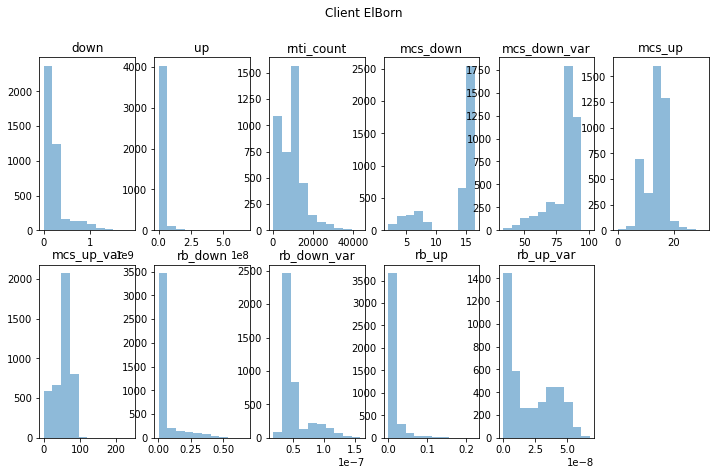


Client name: LesCorts
 - Features:


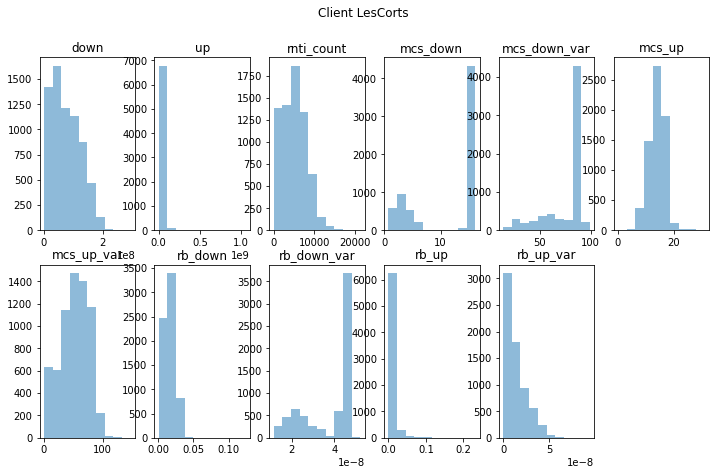


Client name: PobleSec
 - Features:


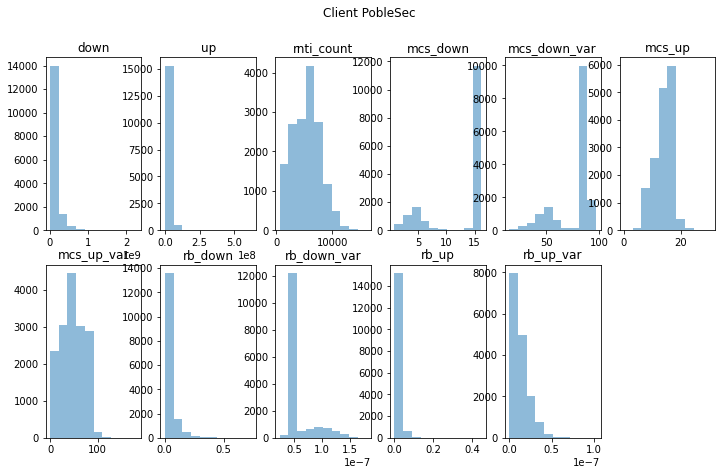

In [ ]:
for client in train_dataset:

    # Get data from features and labels
    print('')
    print(f"Client name: {client}")
    client_dataset = train_dataset.get(client)
    x = client_dataset

    # Plot hist of feature values
    print(' - Features:')
    f = plt.figure(figsize=(12, 7))
    f.suptitle(f"Client {client}")
    i = 0
    for feature in x:
        plt.subplot(2, 6, i + 1)
        plt.title(feature)
        plt.hist(x.get(feature), alpha=0.5)
        i = i + 1
    plt.show()


Client name: ElBorn


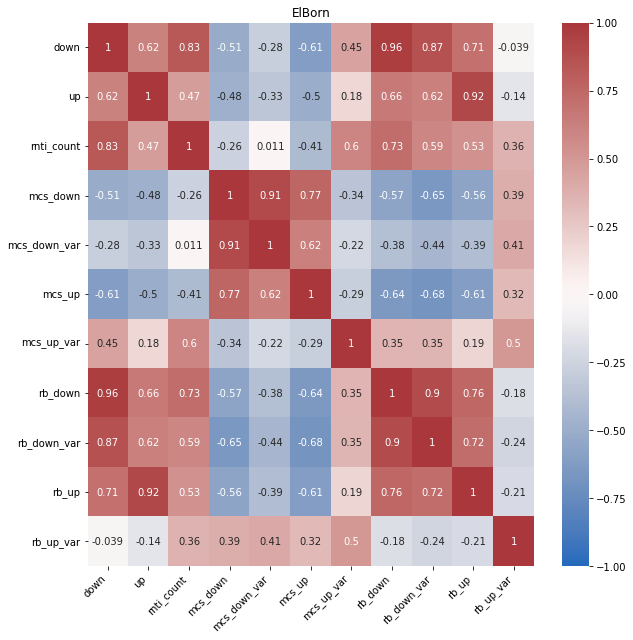


Client name: LesCorts


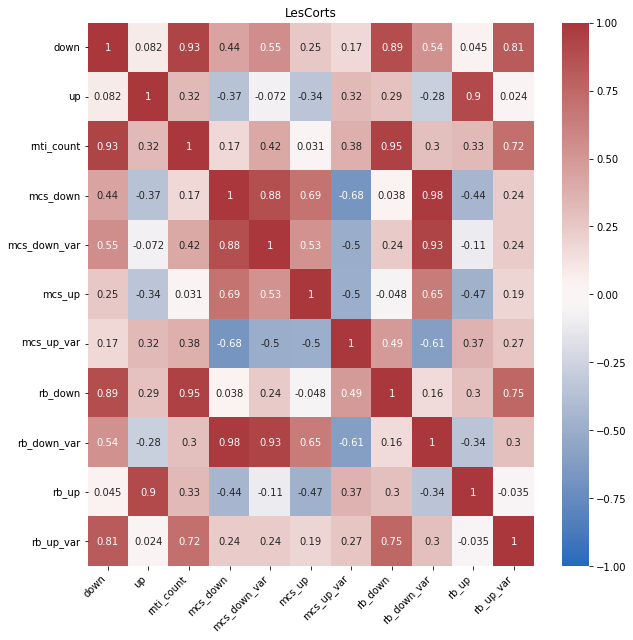


Client name: PobleSec


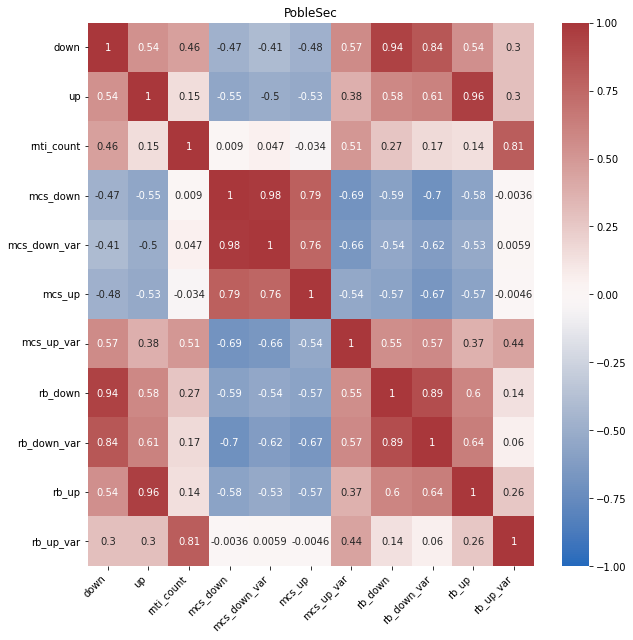

In [ ]:
# Define the name of the features in the dataset
import seaborn as sns
features = ["down", "up", "rnti_count", "mcs_down", "mcs_down_var", "mcs_up", "mcs_up_var", 
            "rb_down", "rb_down_var", "rb_up", "rb_up_var"]
# Plot correlation for each location
for client in train_dataset:

    # Get data from features and labels
    print('')
    print(f"Client name: {client}")
    client_dataset = train_dataset.get(client)
    x = client_dataset
    
    # Generate the plot
    f = plt.figure(figsize=(10, 10))
    R1 = x.corr()
    ax = sns.heatmap(R1, annot=True, cmap='vlag', vmin=-1, vmax=1)
    ax.set_xticklabels(features, rotation=45, horizontalalignment='right')
    ax.set_yticklabels(features, rotation=0, horizontalalignment='right')
    plt.title(client)
    plt.show()

In [ ]:
def CNN(inputShape, nVarsOut, nFuture=1, nFilters=16, kernelSize1=[16, 3], kernelSize2=[3, 5], kernelSize3=[8, 3],
              kernelSize4=[4, 3], poolSize=[2, 1], mask='11111'):
  
    model = Sequential([
        Conv2D(filters=nFilters, kernel_size=kernelSize1, padding="same", activation="relu",
               trainable=bool(int(mask[0])), name='Conv2D_1',
               input_shape=inputShape),

        Conv2D(filters=nFilters, kernel_size=kernelSize2, padding="same", activation="relu",
               trainable=bool(int(mask[1])), name='Conv2D_2'),

        Conv2D(filters=nFilters * 2, kernel_size=kernelSize3, padding="same", activation="relu",
               trainable=bool(int(mask[2])), name='Conv2D_3'),

        Conv2D(filters=nFilters * 2, kernel_size=kernelSize4, padding="same", activation="relu",
               trainable=bool(int(mask[3])), name='Conv2D_4'),

        AveragePooling2D(pool_size=poolSize, name='AveragePooling'),

        Flatten(name='flatten'),

        Dense(nFuture * nVarsOut, activation='tanh', name='forecast', trainable=bool(int(mask[4])))  # [-1, 1]
        
    ],
        name=f'CNN_{nPast}to{nFuture}_{nFilters}-{kernelSize1[0]}x{kernelSize1[1]}_{nFilters}-{kernelSize2[0]}x{kernelSize2[1]}_{nFilters * 2}-{kernelSize3[0]}x{kernelSize3[1]}_{nFilters * 2}-{kernelSize4[0]}x{kernelSize4[1]}_finalPooling{poolSize[0]}x{poolSize[1]}_' + mask
    )

    model.compile(optimizer=Adam(),
                  loss=MSE(),
                  metrics=[MeanAbsoluteError()])

    print(model.summary(), flush=True)

    return model

In [ ]:
# Define the location to be used
location_name = 'LesCorts' # Available sites: ElBorn, PobleSec, LesCorts
print("Selected site: " + location_name)

# Define the set of features and labels in the dataset
features = ["down", "up", "rnti_count", "mcs_down", "mcs_down_var", "mcs_up", "mcs_up_var", 
            "rb_down", "rb_down_var", "rb_up", "rb_up_var"]

print(train_dataset.get(location_name))

# Load the data from the training dataset
processed_data = train_dataset.get(location_name).loc[:,['rnti_count', 'rb_down', 'rb_up', 'mcs_down', 'mcs_up', 'down', 'up']].astype('float32').fillna(0)

# Split data into training and validation
train_percentage = 0.8
num_samples_train = math.ceil(train_percentage*len(processed_data))
print(f"- Total number of samples:  {len(processed_data)}")
print(f"- Number of samples for training: {num_samples_train}")
print(f"- Number of samples for validation:  {len(processed_data)-num_samples_train}")
train_data = processed_data[:num_samples_train]
val_data = processed_data[num_samples_train:]

scalerX = MinMaxScaler(feature_range=(-1,1))
scalerY = MinMaxScaler(feature_range=(-1,1))

# numpy arrays from here on
X_train = scalerX.fit_transform(train_data.loc[:,['rb_down', 'rb_up', 'rnti_count', 'mcs_down', 'mcs_up']])
X_train = X_train[..., np.newaxis] # CNN requested shape
X_val = scalerX.transform(val_data.loc[:,['rb_down', 'rb_up', 'rnti_count', 'mcs_down', 'mcs_up']])
X_val = X_val[..., np.newaxis] # CNN requested shape
Y_train = scalerY.fit_transform(train_data.loc[:,['rnti_count', 'rb_down', 'rb_up', 'down', 'up']])
Y_val = scalerY.transform(val_data.loc[:,['rnti_count', 'rb_down', 'rb_up', 'down', 'up']])

print('FEATURES training data:')
print(X_train)
print('LABELS training data:')
print(Y_train)

Selected site: LesCorts
                           down          up  rnti_count   mcs_down  \
2019-01-12 17:12:00  38490328.0  18729576.0        4495   2.573617   
2019-01-12 17:14:00  28093304.0  19340160.0        4277   2.104966   
2019-01-12 17:16:00  32971216.0  20630232.0        4729   2.452463   
2019-01-12 17:18:00  28745776.0  13323504.0        3924   2.072077   
2019-01-12 17:20:00  30887688.0  13812144.0        4099   2.241337   
...                         ...         ...         ...        ...   
2019-01-22 06:46:00  48370808.0    231664.0        2929  15.198009   
2019-01-22 06:48:00  44972096.0    184784.0        2847  15.449166   
2019-01-22 06:50:00  31460120.0     33088.0        1997  15.330073   
2019-01-22 06:52:00  28048016.0     48072.0        1748  15.351619   
2019-01-22 06:54:00  41325736.0    158248.0        2563  15.173839   

                     mcs_down_var     mcs_up  mcs_up_var   rb_down  \
2019-01-12 17:12:00     45.616769  13.382755   71.070384  0.01361

In [ ]:
nPast = 10                  # Number of past samples used for predictions (equivalent to 20 minutes)
nFuture = 1                 # Number of future samples to be predicted (equivalent to 2 minutes)
windowSize = 1              # Window size (time-series forecasting)
nEpochs = 100                # Number of epochs
batch_size = 128            # Batch size (other options: [64, 32])
nRep = 2                   # Number of repetitions whereby the model will be trained

nVarsOut = Y_val.shape[1]             # Output shape
inputShape = nPast, X_val.shape[1], 1 # Input shape based on the number of past observations and the shape of the validation data

loss1 = MSE(reduction='sum')
loss2 = MAE(reduction='sum')

In [ ]:
model = CNN(inputShape, nVarsOut, nFuture)
# Define the train and validation time-series
genValLosses = TimeseriesGenerator(X_val, Y_val, nPast, stride=windowSize, batch_size=1)  # BS always 1 here!
genTrain = TimeseriesGenerator(X_train, Y_train, nPast, stride=windowSize, batch_size=batch_size)
genVal = TimeseriesGenerator(X_val, Y_val, nPast, stride=windowSize, batch_size=batch_size)

# Define arrays to store performance metrics 
avg = {'loss': np.zeros(nEpochs), 'val_loss': np.zeros(nEpochs), 'mean_absolute_error': np.zeros(nEpochs),
        'val_mean_absolute_error': np.zeros(nEpochs)}

# Train the model for nRep repetitions
for i in range(nRep):                
    history = model.fit(genTrain, epochs=nEpochs, validation_data=genVal, verbose=2)
    avg['loss'] += np.array(history.history['loss'])
    avg['val_loss'] += np.array(history.history['val_loss'])
    avg['mean_absolute_error'] += np.array(history.history['mean_absolute_error'])
    avg['val_mean_absolute_error'] += np.array(history.history['val_mean_absolute_error'])

# Compute the average performance obtained across nRep repetitions
avg = {k: v / nRep for k, v in avg.items()}

Model: "CNN_10to1_16-16x3_16-3x5_32-8x3_32-4x3_finalPooling2x1_11111"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv2D_1 (Conv2D)           (None, 10, 5, 16)         784       
                                                                 
 Conv2D_2 (Conv2D)           (None, 10, 5, 16)         3856      
                                                                 
 Conv2D_3 (Conv2D)           (None, 10, 5, 32)         12320     
                                                                 
 Conv2D_4 (Conv2D)           (None, 10, 5, 32)         12320     
                                                                 
 AveragePooling (AveragePool  (None, 5, 5, 32)         0         
 ing2D)                                                          
                                                                 
 flatten (Flatten)           (None, 800)               0         
      

In [ ]:
# Save the model 
model.save_weights(f'./CNN_{location_name}_GS{windowSize}_BS{batch_size}_{nPast}to{nFuture}.h5')
# Download the model 
from google.colab import files
files.download(f'./CNN_{location_name}_GS{windowSize}_BS{batch_size}_{nPast}to{nFuture}.h5')

# Load the model
model.load_weights(f'./CNN_{location_name}_GS{windowSize}_BS{batch_size}_{nPast}to{nFuture}.h5')

# Process the test data set
processed_data = test_dataset.get(location_name).loc[:,['rnti_count', 'rb_down', 'rb_up', 'mcs_down', 'mcs_up', 'down', 'up']].astype('float32').fillna(0)
X_test = scalerX.transform(processed_data.loc[:, ['rb_down', 'rb_up', 'rnti_count', 'mcs_down', 'mcs_up']])
X_test = X_test[..., np.newaxis]  
Y_test = scalerY.transform(processed_data.loc[:, ['rnti_count', 'rb_down', 'rb_up', 'down', 'up']])

# # Evaluate the model on the test dataset
# if windowSize == 0:
#     X_test_gen = X_test
# elif windowSize > 0:
#     X_test_gen = X_test[:-windowSize]

genTestLosses = TimeseriesGenerator(X_test, Y_test, nPast, stride=windowSize, batch_size=1)  # BS always 1 here!
genTest = TimeseriesGenerator(X_test, Y_test, nPast, stride=windowSize, batch_size=batch_size)
avg = {'loss': np.zeros(nEpochs), 'val_loss': np.zeros(nEpochs), 'mean_absolute_error': np.zeros(nEpochs),
        'val_mean_absolute_error': np.zeros(nEpochs)}

model.evaluate(genTest)

In [ ]:
tracker = CarbonTracker(epochs=1, components="gpu", verbose=1)
# Start the measurement
tracker.epoch_start()   
# Run a training epoch                 
history = model.fit(genTrain, epochs=nEpochs, validation_data=genVal, verbose=2)
# End the measurement
tracker.epoch_end()

tracker.stop()

CarbonTracker: The following components were found: GPU with device(s) Tesla T4.
Epoch 1/100
43/43 - 1s - loss: 0.0050 - mean_absolute_error: 0.0395 - val_loss: 0.0064 - val_mean_absolute_error: 0.0465 - 593ms/epoch - 14ms/step
Epoch 2/100
43/43 - 0s - loss: 0.0050 - mean_absolute_error: 0.0388 - val_loss: 0.0068 - val_mean_absolute_error: 0.0491 - 311ms/epoch - 7ms/step
Epoch 3/100
43/43 - 0s - loss: 0.0049 - mean_absolute_error: 0.0388 - val_loss: 0.0067 - val_mean_absolute_error: 0.0482 - 262ms/epoch - 6ms/step
Epoch 4/100
43/43 - 0s - loss: 0.0049 - mean_absolute_error: 0.0388 - val_loss: 0.0071 - val_mean_absolute_error: 0.0477 - 250ms/epoch - 6ms/step
Epoch 5/100
43/43 - 0s - loss: 0.0059 - mean_absolute_error: 0.0444 - val_loss: 0.0077 - val_mean_absolute_error: 0.0494 - 262ms/epoch - 6ms/step
Epoch 6/100
43/43 - 0s - loss: 0.0052 - mean_absolute_error: 0.0404 - val_loss: 0.0063 - val_mean_absolute_error: 0.0460 - 279ms/epoch - 6ms/step
Epoch 7/100
43/43 - 0s - loss: 0.0048 - me

# Dataset Manipulation


In [ ]:
!pip install --quiet carbontracker
!pip install --quiet tornado==4.5.3
!pip install --quiet tensorflow-federated==0.20.0
!pip install --quiet tf-nightly
!pip install --quiet nest-asyncio
import pickle 
import numpy as np 
import pandas as pd
import gzip, pickle
import requests
import urllib.request
import math
import matplotlib.pyplot as plt
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.layers import Input, GRU, Dense, Flatten, Reshape, BatchNormalization, LayerNormalization, Conv2D, \
    SeparableConv2D, AveragePooling2D
from keras.models import Model, Sequential  
from tensorflow.keras.optimizers import Adam
from keras.losses import MeanSquaredError as MSE, MeanAbsoluteError as MAE
from keras.metrics import MeanAbsoluteError
from sklearn.preprocessing import MinMaxScaler
import os
import sys
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from carbontracker.tracker import CarbonTracker
from carbontracker import parser
import collections
import tensorflow as tf
import tensorflow_federated as tff
import random
import time
import nest_asyncio
import keras

# Federatice Approach

In [ ]:
# PARAMETERS

NUM_CLIENTS = 10              # Number of FL clients to be invoked in each FL round
NUM_EPOCHS = 5                # Number of epochs used for local training
NUM_CLASSES_PER_USER = 3      # Number of classes in each FL client
BATCH_SIZE = 20               # Size of the batch considered by FL devices for local training
SHUFFLE_BUFFER = 100          # Shuffling
PREFETCH_BUFFER = 10          # Prefetching
NUM_ROUNDS_FL = 10            # Number of FL rounds to be simulated
LEARNING_RATE_CLIENT = 0.01   # Clients' learning rate
LEARNING_RATE_SERVER = 1.00   # Server's learning rate

np.random.seed(1000)

# METHODS

# Pre-processing function
def preprocess(dataset):
    def batch_format_fn(element):
        """Flatten a batch `pixels` and return the features as an `OrderedDict`."""
        return collections.OrderedDict(
            x=tf.reshape(element['pixels'], [-1, 784]),
            y=tf.reshape(element['label'], [-1, 1]))
    return dataset.repeat(NUM_EPOCHS).shuffle(SHUFFLE_BUFFER, seed=1).batch(
        BATCH_SIZE).map(batch_format_fn).prefetch(PREFETCH_BUFFER)


# Make data federated
def make_federated_data(client_data, client_ids):
    return [
        preprocess(client_data.create_tf_dataset_for_client(x))
        for x in client_ids
    ]


def create_keras_model():
    return tf.keras.models.Sequential([
        tf.keras.layers.InputLayer(input_shape=(784)),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dense(10, kernel_initializer='zeros'),
        tf.keras.layers.Softmax(),
    ])

In [ ]:
emnist_train, emnist_test = tff.simulation.datasets.emnist.load_data()
example_dataset = emnist_train.create_tf_dataset_for_client(emnist_train.client_ids[0])

In [ ]:
emnist_train.client_ids[0][:]

'f0000_14'

In [ ]:
preprocessed_example_dataset = preprocess(example_dataset)
sample_batch = tf.nest.map_structure(lambda x: x.numpy(), next(iter(preprocessed_example_dataset)))
sample_clients = emnist_train.client_ids[0:NUM_CLIENTS]
fed_train_data = make_federated_data(emnist_train, sample_clients)

In [ ]:
example_dataset = train_data.create_tf_dataset_for_client(train_dataset['ElBorn'])

In [ ]:
train_data.


In [ ]:
train_client_ids   = ['ElBorn','LesCorts']
test_client_ids   = ['PobleSec']
client_id_colname = ['ElBorn','LesCorts','PobleSec']

In [ ]:
def create_tf_dataset_for_client_fn(client_id):
  # a function which takes a client_id and returns a
  # tf.data.Dataset for that client
  client_data = pd.concat([train_dataset['ElBorn'], train_dataset['LesCorts']])
  dataset = tf.data.Dataset.from_tensor_slices(client_data.to_dict('list'))
  dataset = dataset.shuffle(SHUFFLE_BUFFER).batch(1).repeat(NUM_EPOCHS)
  return dataset

train_data = tff.simulation.datasets.ClientData.from_clients_and_tf_fn(
        client_ids=train_client_ids,
        serializable_dataset_fn=create_tf_dataset_for_client_fn
    )
# test_data = tff.simulation.datasets.ClientData.from_clients_and_tf_fn(
#         client_ids=test_client_ids,
#         serializable_dataset_fn=create_tf_dataset_for_client_fn
#     )

In [ ]:
def model_fn():
  keras_model = CNN(inputShape, nVarsOut, nFuture)
  return tff.learning.from_keras_model(keras_model, input_spec=preprocessed_example_dataset.element_spec, loss = [tf.keras.losses.SparseCategoricalCrossentropy()])

In [ ]:
iterative_process = tff.learning.algorithms.build_weighted_fed_avg(
    model_fn,
    client_optimizer_fn = lambda: tf.keras.optimizers.SGD(learning_rate = 0.02),
    server_optimizer_fn = lambda: tf.keras.optimizers.SGD(learning_rate = 1),
    )

In [ ]:
preprocessed_example_dataset.element_spec

OrderedDict([('x', TensorSpec(shape=(None, 784), dtype=tf.float32, name=None)),
             ('y', TensorSpec(shape=(None, 1), dtype=tf.int32, name=None))])

In [ ]:
input_spec = tf.nest.map_structure(lambda x: tf.TensorSpec((None, fokol.shape[0]), x.dtype), fokol)

In [ ]:
fokol = client_data

In [ ]:
fokol = fokol.to_numpy()

In [ ]:
input_spec

TensorSpec(shape=(None, 11084), dtype=tf.float64, name=None)

In [ ]:
fokol.shape

(11084, 11)

In [ ]:
from collections import OrderedDict
input_dict = OrderedDict()
input_dict['x'] = tf.nest.map_structure(lambda x: tf.TensorSpec((None, fokol.shape[0]), x.dtype), fokol)
input_dict['y'] = tf.nest.map_structure(lambda x: tf.TensorSpec((None, fokol.shape[1]), x.dtype), fokol)

In [ ]:
input_dict

OrderedDict([('x',
              TensorSpec(shape=(None, 11084), dtype=tf.float64, name=None)),
             ('y', TensorSpec(shape=(None, 11), dtype=tf.float64, name=None))])

# fed approach iter 2

In [ ]:
!pip install --quiet carbontracker
!pip install --quiet tornado==4.5.3
!pip install --quiet tensorflow-federated==0.20.0
!pip install --quiet tf-nightly
!pip install --quiet nest-asyncio

In [ ]:
train_dbfile = open('train.pkl', 'rb')     
train_dataset = pickle.load(train_dbfile)
test_dbfile = open('test.pkl', 'rb')     
test_dataset = pickle.load(test_dbfile)

Client_1 = train_dataset['ElBorn']
Client_2 = train_dataset['LesCorts']
Client_3 = train_dataset['PobleSec']

In [ ]:
client_id_colname = 'character' # the column that represents client ID
data_colname = 'snippets'
def create_tff_dataset_for_csv_file(filepath):
  df = pd.read_csv(filepath)
  client_ids = df[client_id_colname].unique().tolist()
  print(client_ids)

  def create_tf_dataset_for_client_fn(client_id):                       # helper Function that takes the client ids then filter out any null values
    client_data = df[df[client_id_colname] == client_id]                    # Then selects only the data i.e the snippets
    client_data = client_data[client_data[data_colname].notnull()]             # Then returns records dict with client id as key
    client_data = client_data[[data_colname]]
    records = client_data.to_dict('records')
    print(client_data)
    print(records)

    def dataset_gen():
      for row in records:
        yield row
    return tf.data.Dataset.from_generator(dataset_gen,
                                          output_types={data_colname: tf.string},
                                          output_shapes={data_colname: []}
    )

  return tff.simulation.datasets.ClientData.from_clients_and_tf_fn(
      client_ids=client_ids,
      serializable_dataset_fn=create_tf_dataset_for_client_fn
  )

filepath = '/content/shakespeare_train.csv'
df = pd.read_csv(filepath)
train_data = create_tff_dataset_for_csv_file(filepath)

['ALL_S_WELL_THAT_ENDS_WELL_ADAM', 'ALL_S_WELL_THAT_ENDS_WELL_AEDILE', 'ALL_S_WELL_THAT_ENDS_WELL_AGRIPPA', 'ALL_S_WELL_THAT_ENDS_WELL_ALEXAS', 'ALL_S_WELL_THAT_ENDS_WELL_ALL', 'ALL_S_WELL_THAT_ENDS_WELL_ALL_THE_PEOPLE', 'ALL_S_WELL_THAT_ENDS_WELL_AMIENS', 'ALL_S_WELL_THAT_ENDS_WELL_ANTIPHOLUS_OF_EPHESUS', 'ALL_S_WELL_THAT_ENDS_WELL_ANTONY', 'ALL_S_WELL_THAT_ENDS_WELL_ARVIRAGUS', 'ALL_S_WELL_THAT_ENDS_WELL_AUDREY', 'ALL_S_WELL_THAT_ENDS_WELL_AUFIDIUS', 'ALL_S_WELL_THAT_ENDS_WELL_BELARIUS', 'ALL_S_WELL_THAT_ENDS_WELL_BOTH', 'ALL_S_WELL_THAT_ENDS_WELL_BOTH_TRIBUNES', 'ALL_S_WELL_THAT_ENDS_WELL_BROTHERS', 'ALL_S_WELL_THAT_ENDS_WELL_BRUTUS', 'ALL_S_WELL_THAT_ENDS_WELL_CAESAR', 'ALL_S_WELL_THAT_ENDS_WELL_CANIDIUS', 'ALL_S_WELL_THAT_ENDS_WELL_CAPTAIN', 'ALL_S_WELL_THAT_ENDS_WELL_CELIA', 'ALL_S_WELL_THAT_ENDS_WELL_CENTURION', 'ALL_S_WELL_THAT_ENDS_WELL_CHARLES', 'ALL_S_WELL_THAT_ENDS_WELL_CHARMIAN', 'ALL_S_WELL_THAT_ENDS_WELL_CITIZEN', 'ALL_S_WELL_THAT_ENDS_WELL_CITIZENS', 'ALL_S_WELL_THAT_EN

In [ ]:
def create_tf_dataset_for_client_fn('ALL_S_WELL_THAT_ENDS_WELL_ADAM'):                       # helper Function that takes the client ids then filter out any null values
  client_data = df[df[client_id_colname] == client_id]                    # Then selects only the data i.e the snippets
  client_data = client_data[client_data[data_colname].notnull()]             # Then returns records dict with client id as key
  client_data = client_data[[data_colname]]
  records = client_data.to_dict('records')
  print(client_data)
  print(records)


In [ ]:
Client_1

,down,up,rnti_count,mcs_down,mcs_down_var,mcs_up,mcs_up_var,rb_down,rb_down_var,rb_up,rb_up_var
2018-03-28 15:56:00,174876888.0,1856888.0,10229,15.332298,87.157688,14.981497,49.989484,0.029681,4.497698e-08,0.000541,3.143297e-08
2018-03-28 15:58:00,209054184.0,2866200.0,12223,15.116846,87.192168,16.432612,62.494670,0.035971,4.615535e-08,0.000852,4.439640e-08
2018-03-28 16:00:00,191464640.0,1935360.0,11152,15.215739,87.227955,15.885238,63.087007,0.032750,4.646104e-08,0.000607,2.993595e-08
2018-03-28 16:02:00,241515688.0,2991152.0,14040,15.135400,86.199501,15.714660,77.187459,0.041372,4.532153e-08,0.000925,5.382563e-08
2018-03-28 16:04:00,264131088.0,3288816.0,15247,15.188944,86.151119,15.414080,69.118561,0.045074,4.655543e-08,0.001021,5.922178e-08
...,...,...,...,...,...,...,...,...,...,...,...
2018-04-03 11:30:00,128110784.0,1088280.0,7758,14.980204,86.783498,14.489431,35.620732,0.021526,4.404124e-08,0.000380,1.945518e-08
2018-04-03 11:32:00,151273208.0,1283992.0,9103,15.013859,87.903331,16.019702,42.272334,0.025785,4.499877e-08,0.000444,2.165493e-08
2018-04-03 11:34:00,149891584.0,1222184.0,8923,15.202415,86.370911,16.476345,34.919566,0.025406,4.622009e-08,0.000373,1.820744e-08
2018-04-03 11:36:00,155997488.0,1331536.0,9309,15.051294,87.701243,15.943630,51.888593,0.026372,4.449000e-08,0.000388,1.931032e-08
